# Example for the Beijing Air Quality 2.5 Dataset

https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [2]:
import sys

import dill

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

from sklearn import linear_model

sys.path.insert(0, './../../')

from tsmule.xai.lime import LimeTS

In [3]:
cnn_model = keras.models.load_model('./beijing_air_2_5_cnn_model.h5')
dnn_model = keras.models.load_model('./beijing_air_2_5_dnn_model.h5')
rnn_model = keras.models.load_model('./beijing_air_2_5_rnn_model.h5')

with open('./beijing_air_2_5_test_data.dill', 'rb') as f:
    dataset_test = dill.load(f)

## Take a sample and visualize it

In [4]:
idx = 0

sample = dataset_test[0][idx]
label = dataset_test[1][idx]

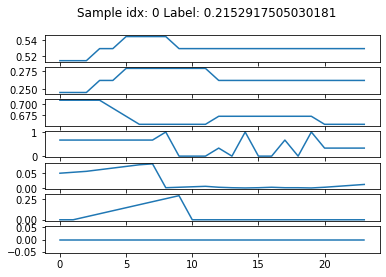

In [5]:
_, features = sample.shape
fig, axs = plt.subplots(features)
for i in range(features):
    axs[i].plot(sample[:, i])
fig.suptitle('Sample idx: ' + str(idx) + ' Label: ' + str(label))
plt.show()

## Probe CNN

In [6]:
def predict_fn(x):
    if len(x.shape) == 2:
        prediction = cnn_model.predict(x[np.newaxis]).ravel()
    else:
        prediction = cnn_model.predict(x).ravel()
    return prediction

explainer = LimeTS()

### Visualize segments

/home/udo/anaconda3/envs/playground/lib/python3.7/site-packages/stumpy/core.py:443: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(welford_nanvar(a, w))
A large number of values are smaller than 1e-05.
For a self-join, try setting `ignore_trivial = True`.


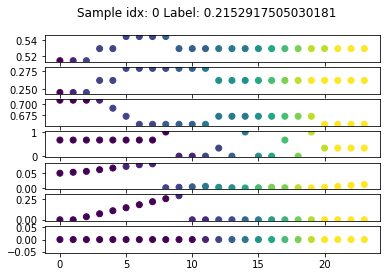

In [7]:
seg_m = explainer._segmenter.segment(sample, 'slopes-max')

n_steps, features = sample.shape
fig, axs = plt.subplots(features)
for i in range(features):
    axs[i].scatter(range(n_steps), sample[:, i], c=seg_m[:, i])
fig.suptitle('Sample idx: ' + str(idx) + ' Label: ' + str(label))
plt.show()


### Visualize perturbations

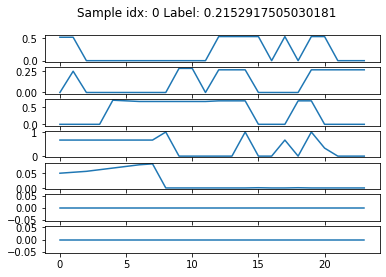

In [15]:
perturbed_samples = explainer._sampler.perturb(sample, seg_m)
new_s, z_prime, pi = next(perturbed_samples)

fig, axs = plt.subplots(features)
for i in range(features):
    axs[i].plot(new_s[:, i])
fig.suptitle('Sample idx: ' + str(idx) + ' Label: ' + str(label))
plt.show()

### Visualize mask

In [16]:
fig, ax = plt.subplots()
ax.imshow(z_prime.reshape(-1, features).T)
plt.show()

ValueError: cannot reshape array of size 76 into shape (7)

### Create explanations

/home/udo/anaconda3/envs/playground/lib/python3.7/site-packages/stumpy/core.py:443: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(welford_nanvar(a, w))
A large number of values are smaller than 1e-05.
For a self-join, try setting `ignore_trivial = True`.


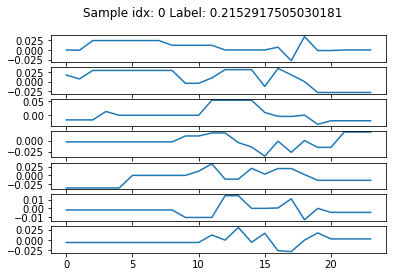

In [20]:
lasso_classifier = linear_model.Lasso(alpha=0.0001)
explainer._kernel = lasso_classifier

xcoef = explainer.explain(sample, predict_fn)

fig, axs = plt.subplots(features)
for i in range(features):
    axs[i].plot(xcoef[:, i])
fig.suptitle('Sample idx: ' + str(idx) + ' Label: ' + str(label))
plt.show()